In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import statsmodels.formula.api as smf

pd.options.display.max_columns = 2000
pd.options.display.max_rows = 200

In [16]:
def print_def(variable_name):
    """
    Pass in a variable name as a string, print its defintion.
    Definitions included with the original dataset. 
    Only works with ORIGINAL feature names.
    """
    
    try:
        if  not ("definitions_" in globals()):
            try:
                global definitions_
                definitions_ = pd.read_csv("LC_definitions.csv")       
            except:
                print(f"Could not find \"LC_definitions.csv\" in {pwd}.")
        print(variable_name, "-", definitions_.loc[definitions_.LoanStatNew == variable_name, "Description"].iloc[0])
    except:
        print("New feature, not in original dictionary.")

In [28]:
# Either pass in a list of columns to use via logit_cols_ 
# or pass in a list of columns to drop via logit_drop_
def smf_logit(df_, y_, logit_cols_=None, logit_drop_=None):
    if logit_drop_:
        sm_df = df_.drop(labels=logit_drop_, axis=1).dropna()
    elif logit_cols_:
        sm_df = df_.loc[:, logit_cols_+[y_]].copy().dropna()   
    else:
        sm_df = df_.copy().dropna()
        
    formula = y_ + " ~ "
    for column in sm_df.drop(labels=[y_], axis=1).columns:
        formula += column + " + "
    formula = formula[:-3]
    
    print("Formula") 
    print("-------", "\n", f"{formula}\n")
    sm_model = smf.logit(formula, data=sm_df).fit()
    print(sm_model.summary())

In [58]:
def lift_chart(model, X_trainf, X_testf, y_trainf, y_testf, bins=10):
    """
    This function takes a fitted sklearn.linear_model LogisticRegression object along
    with a split dataset and plt.show()'s  a lift chart. 
    Requires matplotlib.pyplot imported as plt.
    Requires numpy imported as np
    
    Parameters
    ----------
    model: sklearn.linear_model.LogisticRegression()
        A fitted LogisticRegression object
    X_trainf: pd.DataFrame.
        Feature training data
    X_testf: pd.DataFrame.
        Feature test/validation data
    y_trainf: pd.Series
        Target training data.
    y_testf: pd.Series
        Target test/validation data.
    bins: Non-zero natural number
        Number of bins to split the data into for plotting.
        Default is 10 bins.
    """
    
    preds_train = model.predict_proba(X_trainf)[:, 1]
    preds_test = model.predict_proba(X_testf)[:, 1]
    
    _df_train = pd.DataFrame()
    _df_train["target"] = y_trainf.copy()
    _df_train["preds"] = preds_train
    _df_train = _df_train.sort_values(by="preds", ascending=False)
    
    _df_test = pd.DataFrame()
    _df_test["target"] = y_testf.copy()
    _df_test["preds"] = preds_test
    _df_test = _df_test.sort_values(by="preds", ascending=False)
    
    max_bias_train = _df_train.target.mean()
    max_bias_test = _df_test.target.mean()
    bin_labels = list(np.arange(1, bins+1, 1))
    
    df_size = len(_df_train)
    bin_size = df_size//bins
    bin_list = [0 + bin_size*i for i in range(bins)]
    bin_probs_train = [_df_train["target"][bin_list[i]:bin_list[i+1]].mean()/max_bias_train for i in range(bins-1)]
    bin_probs_train.append(_df_train["target"][bin_list[bins-1]:].mean())
    
    df_size = len(_df_test)
    bin_size = df_size//bins
    bin_list = [0 + bin_size*i for i in range(bins)]
    bin_probs_test = [_df_test["target"][bin_list[i]:bin_list[i+1]].mean()/max_bias_test for i in range(bins-1)]
    bin_probs_test.append(_df_test["target"][bin_list[bins-1]:].mean())
    
    plt.scatter(bin_labels, bin_probs_train, label="Training Set", s=80, alpha=0.4)
    plt.scatter(bin_labels, bin_probs_test, label="Test Set", s=20, c='black')
    plt.hlines(1, 0, bins, linestyles="dotted")
    #plt.text(x=0.7*len(_df_train), y=0.02+max_bias, s="mean probability")
    plt.title("Lift Chart for P(target=1)")
    plt.xlabel(f"Sorted+Binned Prediction Probabilities, {bins} bins")
    plt.ylabel(f"Lift")
    plt.legend()
    return plt.show()

In [45]:
# read in datasets
df_train = pd.read_csv("lending_club_sample_preprocessed_train.csv")
df_test = pd.read_csv("lending_club_sample_preprocessed_test.csv")
df_validate = pd.read_csv("lending_club_sample_preprocessed_validate.csv")
df_biased = pd.read_csv("lending_club_biased_preprocessed.csv")

In [48]:
# Drop duplicate target column and object-type date columns
XG_drop_cols = ["loan_status"]+list(df_train.select_dtypes(include='object').columns)

df_train = df_train.drop(labels=XG_drop_cols, axis=1)
df_test = df_test.drop(labels=XG_drop_cols, axis=1)
df_validate = df_validate.drop(labels=XG_drop_cols, axis=1)
df_biased = df_biased.drop(labels=XG_drop_cols, axis=1)

In [49]:
df_train.head()

,funded_amnt,installment,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_il_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,term_36months,initial_list_status_w,individual,hardhship,employed_over_10yrs,emp_years,interest_rate,revolving_util,issue_date_year,years_since_earliest_cr_line,target,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,issue_date_month_1,issue_date_month_2,issue_date_month_3,issue_date_month_4,issue_date_month_5,issue_date_month_6,issue_date_month_7,issue_date_month_8,issue_date_month_9,issue_date_month_10,issue_date_month_11,issue_date_month_12
0,8000.0,293.37,49355.8,32.47,0.0,704.0,1.0,12.0,0.0,2638.0,18.0,7396.240000,7396.24,4858.69,2522.55,15.00,0.00,293.37,619.0,0.0,0.0,0.0,83307.0,13700.0,6.0,6942.0,8796.0,9.3,0.0,0.0,121.0,124.0,7.0,3.0,0.0,7.0,3.0,1.0,3.0,4.0,10.0,7.0,4.0,12.0,0.0,0.0,0.0,4.0,83.3,0.0,0.0,0.0,78243.0,83307.0,9700.0,64543.0,1,0,1,0,1,10.0,19.03,19.3,2017,10.0,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,15000.0,341.22,55000.0,23.91,0.0,704.0,0.0,13.0,0

In [50]:
# A list of 1 category from each object set as well as DateTime features for ease of dropping.
logit_drop_cols = ["grade_G", "sub_grade_G5", "home_ownership_NONE", 
                   "purpose_other", "addr_state_WY", "issue_date_month_12"] + \
                    list(df.select_dtypes(include='datetime').columns)

# df.drop(labels=logit_drop_cols, axis=1, inplace=True)

In [54]:
# Run a simple logistic regression using statsmodels
use_cols = ["last_fico_range_high", "last_pymnt_amnt", "total_rec_prncp", 
            "funded_amnt", "issue_date_year", "installment", 
            "total_pymnt_inv", "total_pymnt"]

smf_logit(df_train, "target", logit_cols_=use_cols)

Formula
------- 
 target ~ last_fico_range_high + last_pymnt_amnt + total_rec_prncp + funded_amnt + issue_date_year + installment + total_pymnt_inv + total_pymnt

Optimization terminated successfully.
         Current function value: 0.110114
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49991
Method:                           MLE   Df Model:                            8
Date:                Wed, 09 Aug 2023   Pseudo R-squ.:                  0.7067
Time:                        13:28:26   Log-Likelihood:                -5505.7
converged:                       True   LL-Null:                       -18768.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
-------------

Confusion Matrix: 
[[4238   91]
 [ 168  503]]
Accuracy: 0.9482


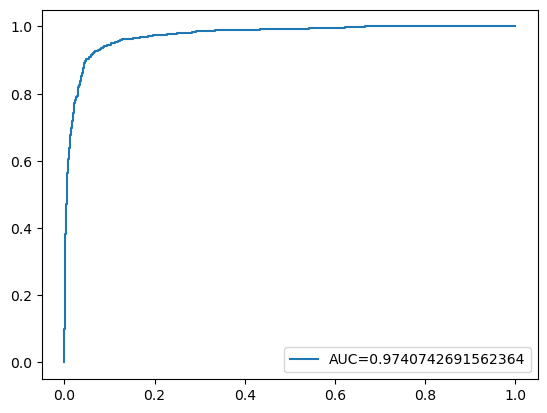

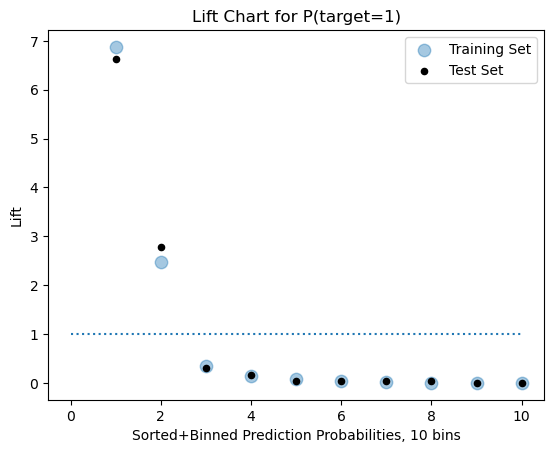

None


In [61]:
# Split target vectors from feature matrices
X_train = df_train.loc[:, use_cols]
y_train = df_train.target

X_test = df_test.loc[:, use_cols]
y_test = df_test.target

#instantiate the model
model = LogisticRegression(max_iter=250)

#fit the model using the training data
model.fit(X_train,y_train)

#use model to make predictions on test data
y_pred = model.predict(X_test)
# confusion matrix [True 0, False 1], [False 0, True 1]
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: \n{cnf_matrix}")
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")

#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

# Lift Chart
print(lift_chart(model, X_train, X_test, y_train, y_test, bins=10))